<a href="https://colab.research.google.com/github/Emmanuel461/Sowing_harvest_predictions/blob/main/Modelado_siembra_2022_SAR_k_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelado de siembra año 2022




In [ ]:
# Instalación de dependencias necesarias
!pip install geopandas rasterio torchsummary tifffile imagecodecs gdal rasterstats pandas openpyxl torchsummary


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 882.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Importar las librerías necesarias
import os
import numpy as np
import torch
import rasterio
from datetime import datetime
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from rasterio import features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import rasterize
from torchsummary import summary
from shapely.geometry import box

# Rutas de archivos
shapefile_path = '/content/drive/MyDrive/TF_data/DataIn/Parcelas_poligono_buffer.geojson'
image_folder_path = '/content/drive/MyDrive/TF_data/SAR_images'  # Carpeta con las imágenes
coregistered_folder = '/content/sample_data'  # Carpeta para las imágenes corregistradas

# Leer el GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Definir fechas de siembra
sowing_dates = {
    1: '27/09/2022',
    2: '23/09/2022',
    3: '28/09/2022',
    4: '25/08/2022',
    5: '17/09/2022'
}

# Convertir las fechas de siembra a días desde una fecha base
base_date = datetime(2022, 7, 1)
sowing_dates_days = {loc_id: (datetime.strptime(date_str, '%d/%m/%Y') - base_date).days for loc_id, date_str in sowing_dates.items()}

# Convertir el diccionario `sowing_dates_days` en un DataFrame para hacer el join
sowing_dates_df = pd.DataFrame(list(sowing_dates_days.items()), columns=['location_id', 'sowing_date_days'])

# Asegurar que ambas columnas 'location_id' sean del mismo tipo
gdf['location_id'] = gdf['location_id'].astype(int)

# Hacer un join entre el `GeoDataFrame` y el `sowing_dates_df` para añadir las etiquetas (labels)
gdf = gdf.merge(sowing_dates_df, on='location_id', how='left')

# Verificar que se haya realizado el join correctamente
print(gdf.head())  # Asegurar que las etiquetas están correctamente asignadas

# Cargar la lista de rutas de imágenes (.tif o .tiff)
image_paths = sorted([os.path.join(image_folder_path, f) for f in os.listdir(image_folder_path) if f.endswith(('.tif', '.tiff'))])

# Función para filtrar imágenes por un rango de fechas
def filter_images_by_date_range(image_paths, start_date, end_date):
    filtered_paths = []
    for path in image_paths:
        filename = os.path.basename(path)  # Obtener el nombre del archivo
        filename_no_ext, _ = os.path.splitext(filename)  # Eliminar la extensión .tif

        parts = filename_no_ext.split('_')  # Dividir por guiones bajos (_)
        if len(parts) >= 7:
            part5 = parts[6]
            file_date_str = part5[:8]
            try:
                file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
                file_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
                # Solo incluir si la fecha está dentro del rango
                if start_date <= file_date <= end_date:
                    filtered_paths.append(path)
            except ValueError:
                print(f"Error al extraer la fecha del archivo {filename}")
                continue
        else:
            print(f"Formato de nombre de archivo incorrecto: {filename}")
    return filtered_paths

# Función para corregistrar imágenes
def coregister_image_to_reference(src_image, reference_image, output_image):
    """
    Esta función reproyecta `src_image` para que esté alineada con la cuadrícula de `reference_image`.
    """
    with rasterio.open(reference_image) as ref:
        # Obtener la transformación, ancho y alto de la imagen de referencia
        transform, width, height = calculate_default_transform(
            ref.crs, ref.crs, ref.width, ref.height, *ref.bounds
        )

        # Actualizar las metadatas de la imagen de salida con la de referencia
        kwargs = ref.meta.copy()
        kwargs.update({
            'crs': ref.crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproyectar la imagen origen al sistema de la imagen de referencia
        with rasterio.open(src_image) as src:
            with rasterio.open(output_image, 'w', **kwargs) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=ref.crs,
                        resampling=Resampling.cubic  # Usamos interpolación cúbica
                    )
    print(f"Imagen {src_image} corregistrada con éxito a {output_image}")

# Buscar bandas por nombre
def select_band_by_name(src, band_names, target_band_names):
    """
    Selecciona las bandas que coincidan con los nombres de banda objetivo.
    """
    band_indices = []
    for target_band_name in target_band_names:
        if target_band_name in band_names:
            band_index = band_names.index(target_band_name) + 1  # rasterio usa índices 1-based
            band_indices.append(band_index)
        else:
            print(f"La banda '{target_band_name}' no se encontró en el archivo. Bandas disponibles: {band_names}")
            return None
    return src.read(band_indices)

# Función para rasterizar las geometrías en la cuadrícula del raster
def mask_image_with_geometries(image, geometries, transform):
    """
    Aplica la máscara a la imagen basada en las geometrías y cuenta los píxeles que tocan la geometría.
    """
    # Usar rasterize con all_touched=True para incluir todos los píxeles que toquen las geometrías
    mask = features.rasterize(
        [(geom, 1) for geom in geometries],
        out_shape=(image.shape[1], image.shape[2]),
        transform=transform,
        fill=0,
        all_touched=True  # Asegurar que se incluyan todos los píxeles que toquen la geometría
    )

    masked_image = np.where(mask == 1, image, -9999)
    pixel_count = np.sum(mask == 1)

    print(f"Se encontraron {pixel_count} píxeles dentro o tocando la geometría.")
    return masked_image, pixel_count

#['dias_julianos', 'Stokes2_DoLP', 'Stokes2_LPR', 'Stokes2_Phi', 'Stokes2_Tau', 'Stokes2_g0', 'Stokes2_g1', 'Stokes2_g2', 'Stokes2_g3', 'Stokes2_l1', 'Stokes2_l2', 'alpha', 'entropy', 'entropy_shannon', 'entropy_shannon_norm', 'span']

# Procesar secuencia completa de imágenes y añadir banda de días julianos
def load_sequence_images(image_paths, gdf, target_band_names=['dias_julianos', 'Stokes2_g2', 'Stokes2_g0', 'entropy', 'entropy_shannon_norm', 'Stokes2_DoLP'], base_date=datetime(2022, 7, 1)):
    sequence = []
    pixel_counts = []
    labels = []  # Aquí almacenamos las etiquetas asociadas a cada polígono
    all_geometries = gdf['geometry']

    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None, None, None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extraer la fecha de la imagen del nombre
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)
        parts = filename_no_ext.split('_')

        if len(parts) < 7:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        part5 = parts[6]
        file_date_str = part5[:8]
        try:
            file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
            image_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
            julian_days = (image_date - base_date).days
            print(f"Días julianos calculados: {julian_days} para la imagen {filename}")
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Abrir la imagen con rasterio y manejar las bandas
        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)
            if all(band_name is None for band_name in band_names):
                print(f"Las bandas del archivo {filename} no tienen nombres. Asignando nombres predefinidos.")
                band_names = target_band_names[1:]

            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Crear una banda para los días julianos
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenar la banda de días julianos con las bandas seleccionadas
                stacked_bands = np.vstack((julian_band, selected_bands))

                # Usar la función unificada de máscara
                masked_bands, pixel_count = mask_image_with_geometries(stacked_bands, all_geometries, src.transform)

                pixel_counts.append(pixel_count)
                sequence.append(masked_bands)

                # Obtener las etiquetas de las geometrías tocadas
                for index, geom in gdf.iterrows():
                    if geom.geometry.intersects(box(*src.bounds)):  # Verifica si la geometría intersecta con la imagen
                        label = geom['sowing_date_days']
                        labels.append(label)

            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:
        print(f"Secuencias cargadas con la banda 'dias_julianos'.")
        print(f"Conteo de píxeles por geometría: {pixel_counts}")
        return np.stack(sequence, axis=0), pixel_counts, labels
    else:
        print("No se pudo cargar ninguna imagen.")
        return None, None, None


# Definir el rango de fechas para cargar imágenes (1 de julio de 2022 a 1 de febrero de 2023)
start_date = datetime(2022, 7, 1)
end_date = datetime(2023, 1, 30)

# Filtrar las imágenes que están dentro del rango de fechas
image_paths_in_range = sorted(filter_images_by_date_range(image_paths, start_date, end_date))

# Corregistrar todas las imágenes usando la primera como referencia
reference_image_path = image_paths_in_range[0]
coregistered_image_paths = []
for image_path in image_paths_in_range:
    output_image_path = os.path.join(coregistered_folder, os.path.basename(image_path))
    coregister_image_to_reference(image_path, reference_image_path, output_image_path)
    coregistered_image_paths.append(output_image_path)

# Cargar y enmascarar las imágenes corregistradas
X_sequences, pixel_counts, y_labels = load_sequence_images(coregistered_image_paths, gdf)

# Verificar el shape de X_sequences y las etiquetas
if X_sequences is not None:
    print(f"Shape de las secuencias: {X_sequences.shape}")
    print(f"Etiquetas (labels): {y_labels}")
    print(f"Conteo de píxeles por geometría: {pixel_counts}")
else:
    print("No se cargaron secuencias.")


   location_id  area_ha   area_m2  polygon_id  \
0            3   0.0140   140.182           1   
1            4   0.0588   587.821           2   
2            1   0.0417   417.453           3   
3            5   0.1239  1239.167           4   
4            2   0.1210  1209.867           5   

                                            geometry  sowing_date_days  
0  MULTIPOLYGON (((-16.45202 12.24534, -16.452 12...                89  
1  MULTIPOLYGON (((-16.44906 12.24442, -16.44908 ...                55  
2  MULTIPOLYGON (((-16.44367 12.24355, -16.44364 ...                88  
3  MULTIPOLYGON (((-16.44028 12.2485, -16.44031 1...                78  
4  MULTIPOLYGON (((-16.44472 12.24445, -16.44472 ...                84  
Imagen /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif corregistrada con éxito a /content/sample_data/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0

In [ ]:

# Inicializar una matriz para las etiquetas
labeled_image = np.full(X_sequences.shape[2:], -1, dtype=np.float32)

# Obtener la referencia espacial de una de las imágenes
with rasterio.open(image_paths_in_range[0]) as src:
    out_meta = src.meta.copy()
    out_transform = src.transform

height, width = labeled_image.shape
location_image = np.full((height, width), np.nan)
# Inicializar labeled_image con -1 (valor que indica sin etiqueta)
labeled_image = np.full((height, width), -1, dtype=np.float32)

# Iterar sobre las geometrías y asignar etiquetas
for idx, row in gdf.iterrows():
    loc_id = row['location_id']
    sowing_date = row['sowing_date_days']
    parcel_geometry = [row['geometry']]

    # Crear una máscara para la geometría de la parcela
    mask_array = rasterio.features.geometry_mask(
        parcel_geometry,
        out_shape=(height, width),
        transform=out_transform,
        invert=True,
        all_touched=True
    )

    # Asignar la fecha de siembra a los píxeles de la parcela
    labeled_image[mask_array] = sowing_date
    location_image[mask_array] = loc_id


# Verificar si hay valores NaN
print(f"Hay NaNs en labeled_image: {np.isnan(labeled_image).any()}")
print(f"Hay NaNs en X_sequences: {np.isnan(X_sequences).any()}")


Hay NaNs en labeled_image: False
Hay NaNs en X_sequences: False


In [ ]:
# Suponiendo que X_sequences tiene la forma (n_imágenes, n_bandas, alto, ancho)
# Creamos una máscara de datos válidos para cada píxel a lo largo de todas las imágenes y bandas
valid_data_mask = np.all(X_sequences != -9999, axis=(0,1))  # Forma: (alto, ancho)

# Podemos verificar cuántos píxeles son válidos en todas las imágenes
num_valid_data_pixels = np.sum(valid_data_mask)
print(f"Número de píxeles con datos válidos en todas las imágenes y bandas: {num_valid_data_pixels}")


Número de píxeles con datos válidos en todas las imágenes y bandas: 101


In [ ]:
# Contar el número de píxeles con etiquetas válidas en labeled_image
num_labeled_pixels = np.sum((labeled_image != -1) & (~np.isnan(labeled_image)))
print(f"Número total de píxeles etiquetados: {num_labeled_pixels}")



Número total de píxeles etiquetados: 101


In [ ]:
unique_values, counts = np.unique(labeled_image[(labeled_image != -1) & (~np.isnan(labeled_image))], return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Etiqueta: {value}, Frecuencia: {count}")


Etiqueta: 55.0, Frecuencia: 19
Etiqueta: 78.0, Frecuencia: 27
Etiqueta: 84.0, Frecuencia: 28
Etiqueta: 88.0, Frecuencia: 17
Etiqueta: 89.0, Frecuencia: 10


In [ ]:
import numpy as np

# Obtener los valores únicos en labeled_image, excluyendo -9999
unique_values = np.unique(labeled_image[labeled_image != -9999])

# Imprimir los valores únicos
print("Valores únicos en labeled_image (excluyendo -9999):", unique_values)

# Contar la frecuencia de cada valor único
for value in unique_values:
    count = np.sum(labeled_image == value)
    print(f"Valor: {value}, Frecuencia: {count}")

Valores únicos en labeled_image (excluyendo -9999): [-1. 55. 78. 84. 88. 89.]
Valor: -1.0, Frecuencia: 47623
Valor: 55.0, Frecuencia: 19
Valor: 78.0, Frecuencia: 27
Valor: 84.0, Frecuencia: 28
Valor: 88.0, Frecuencia: 17
Valor: 89.0, Frecuencia: 10


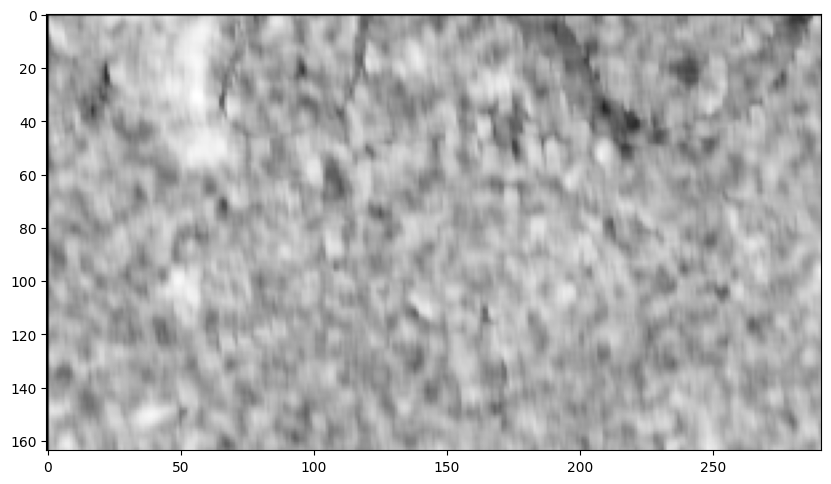

In [ ]:
import matplotlib.pyplot as plt

with rasterio.open(image_paths_in_range[0]) as src:
    image = src.read(1)
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')



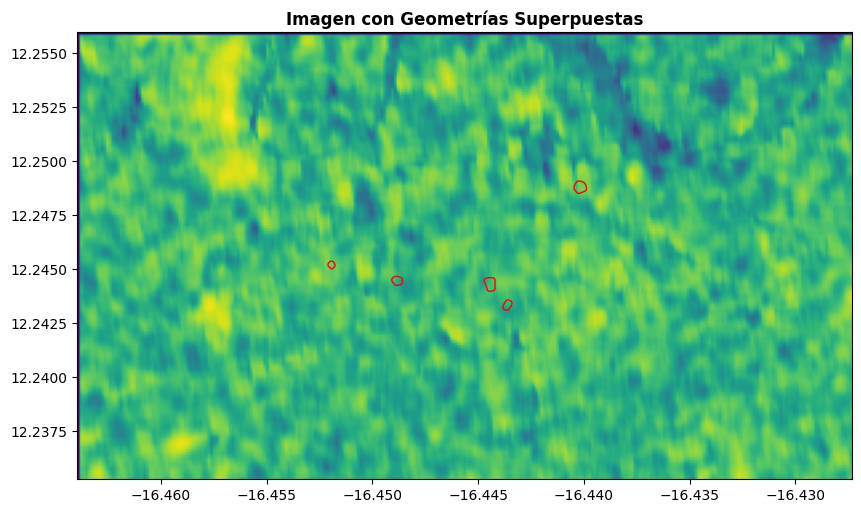

In [ ]:
# Convertir la geometría a coordenadas de imagen
from rasterio.plot import show
#from rasterio.plot import show_bounds # This function has been removed
import matplotlib.pyplot as plt

# Mostrar la imagen
with rasterio.open(image_paths_in_range[0]) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title='Imagen con Geometrías Superpuestas')

    # Superponer las geometrías
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')

plt.show()


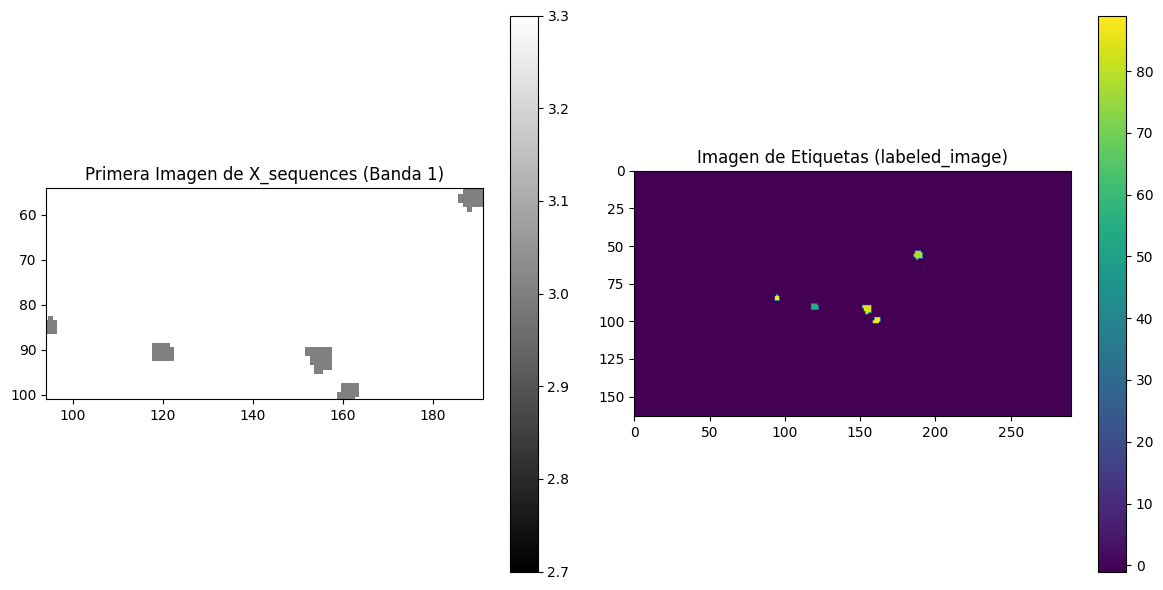

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizar la primera imagen de X_sequences (primera banda y primera imagen en la secuencia)
first_image_X = X_sequences[0, 0, :, :]  # Primera imagen, primera banda

# Visualizar la imagen de etiquetas correspondiente (labeled_image)
first_image_y = labeled_image  # La imagen etiquetada completa

# Encontrar los índices de los píxeles con valores (excluyendo -9999)
valid_indices_X = np.where(first_image_X != -9999)
valid_indices_y = np.where(first_image_y != -9999)

# Obtener los límites para el zoom
xmin_X, xmax_X = valid_indices_X[1].min(), valid_indices_X[1].max()
ymin_X, ymax_X = valid_indices_X[0].min(), valid_indices_X[0].max()

xmin_y, xmax_y = valid_indices_y[1].min(), valid_indices_y[1].max()
ymin_y, ymax_y = valid_indices_y[0].min(), valid_indices_y[0].max()

# Plotear las dos imágenes con zoom
plt.figure(figsize=(12, 6))

# Mostrar la imagen de etiquetas (labeled_image) con zoom
plt.subplot(1, 2, 2)
masked_image_y = np.ma.masked_where(first_image_y == -9999, first_image_y)
plt.imshow(masked_image_y, cmap='viridis')
plt.xlim(xmin_y, xmax_y)  # Ajustar límites del eje x
plt.ylim(ymax_y, ymin_y)  # Ajustar límites del eje y (invertir para que el origen esté arriba)
plt.title('Imagen de Etiquetas (labeled_image)')
plt.colorbar()

# Mostrar la primera imagen de X_sequences con zoom
plt.subplot(1, 2, 1)
masked_image_X = np.ma.masked_where(first_image_X == -9999, first_image_X)
plt.imshow(masked_image_X, cmap='gray')
plt.xlim(xmin_X, xmax_X)  # Ajustar límites del eje x
plt.ylim(ymax_X, ymin_X)  # Ajustar límites del eje y (invertir para que el origen esté arriba)
plt.title('Primera Imagen de X_sequences (Banda 1)')
plt.colorbar()



plt.tight_layout()
plt.show()


In [ ]:
# Reorganizar los datos para la CNN 3D
num_images, num_bands, height, width = X_sequences.shape

# Reorganizar a la forma (n_bandas, n_imágenes, alto, ancho)
X = X_sequences.transpose(1, 0, 2, 3)  # (n_bandas, n_imágenes, alto, ancho)
X = X.astype(np.float32)

# Preparar las etiquetas
y = labeled_image.astype(np.float32)  # (alto, ancho)

# Reemplazar NaNs en y con -1
y[np.isnan(y)] = -1

# Reemplazar NaNs en X_sequences con -1
X_sequences[np.isnan(X_sequences)] = -1

# Reorganizar los datos para el modelo sin parches
num_bands, num_images, height, width = X.shape  # X es de forma (n_bandas, n_imágenes, alto, ancho)

# Aplanar X a (n_samples, n_bandas, n_imágenes)
X_flat = X.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_samples, n_bandas, n_imágenes)

# Aplanar y a (n_samples,)
y_flat = y.flatten()  # (n_samples,)

# Aplanar location_image a (n_samples,)
location_flat = location_image.flatten()

# Crear máscara para filtrar píxeles con etiquetas válidas
valid_mask = ~np.isnan(y_flat) & (y_flat != -1)

# Filtrar X, y y location_id con la máscara
X_flat_valid = X_flat[valid_mask]  # (n_valid_samples, n_bandas, n_imágenes)
y_flat_valid = y_flat[valid_mask]  # (n_valid_samples,)
location_flat_valid = location_flat[valid_mask]  # (n_valid_samples,)

# Verificar que hay datos válidos
if X_flat_valid.shape[0] == 0:
    raise ValueError("No se encontraron píxeles con etiquetas válidas. Verifica tus datos.")

print(f"Shape de X_flat_valid: {X_flat_valid.shape}")
print(f"Shape de y_flat_valid: {y_flat_valid.shape}")
print(f"Shape de location_flat_valid: {location_flat_valid.shape}")


Shape de X_flat_valid: (101, 6, 18)
Shape de y_flat_valid: (101,)
Shape de location_flat_valid: (101,)


In [ ]:
print(y_flat_valid)

[78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78. 78.
 78. 78. 78. 78. 78. 78. 78. 78. 78. 89. 89. 89. 89. 89. 89. 89. 89. 89.
 89. 55. 55. 55. 55. 55. 55. 55. 55. 55. 84. 84. 84. 84. 84. 84. 55. 55.
 55. 55. 55. 84. 84. 84. 84. 84. 84. 55. 55. 55. 55. 55. 84. 84. 84. 84.
 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 84. 88. 88. 88. 88. 88. 88.
 88. 88. 88. 88. 88. 88. 88. 88. 88. 88. 88.]


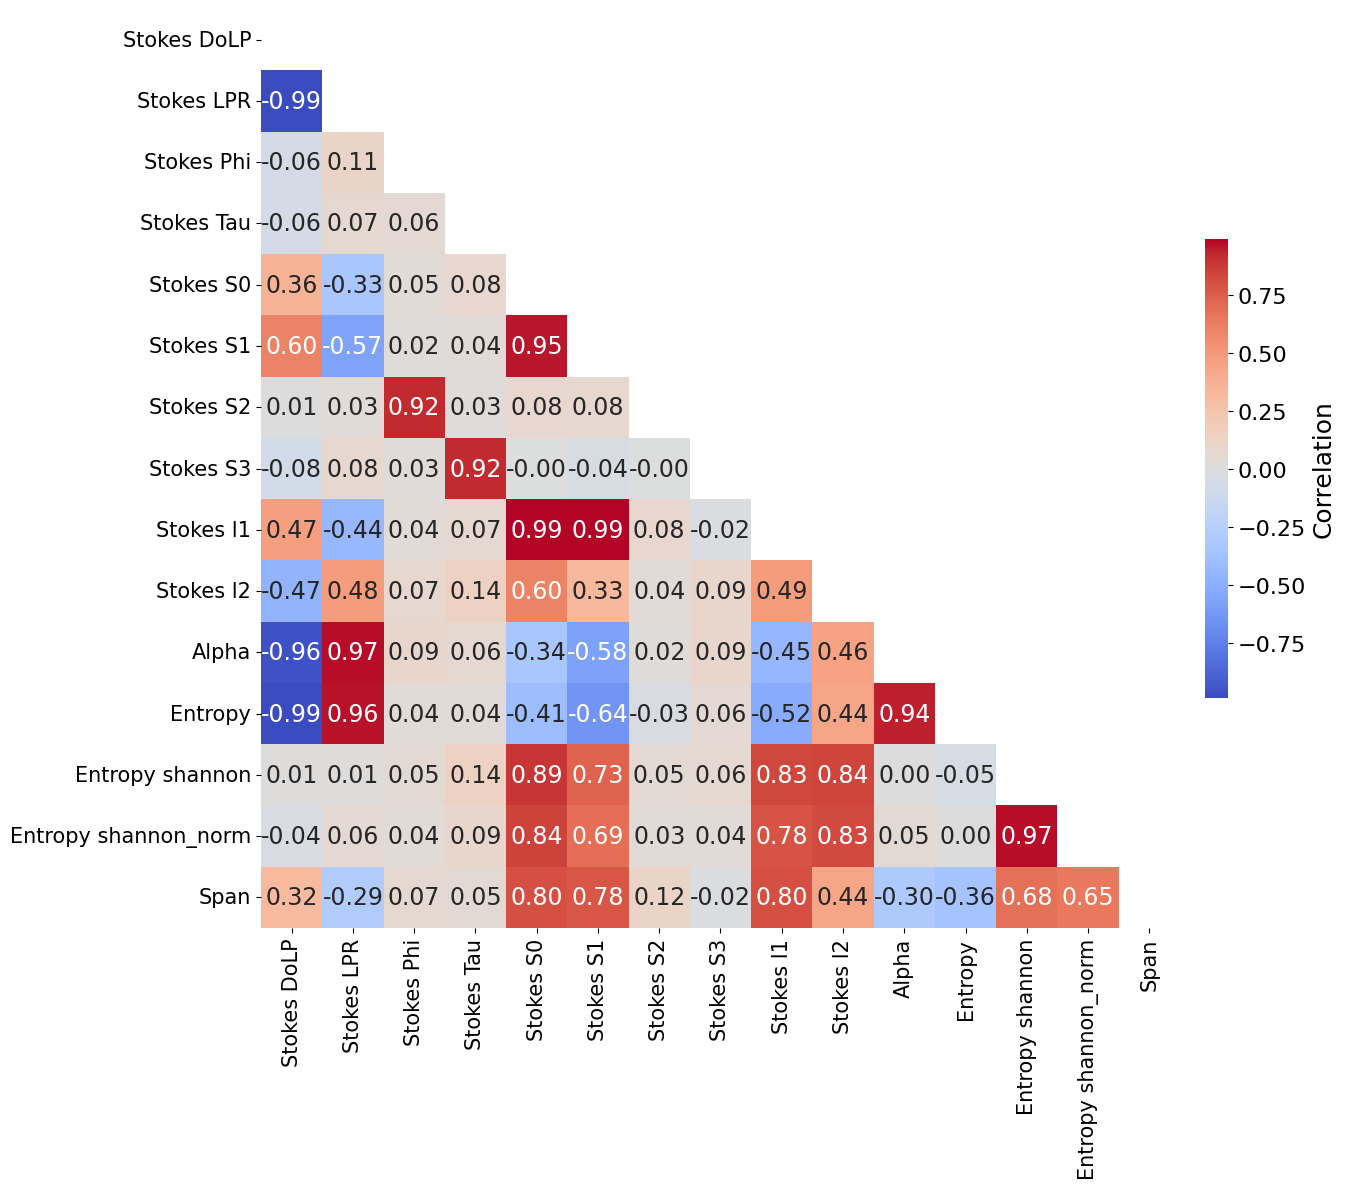

Pares de bandas altamente correlacionadas (umbral > 0.95):
Stokes DoLP y Stokes LPR: correlación = -0.9885
Stokes DoLP y Alpha: correlación = -0.9603
Stokes DoLP y Entropy: correlación = -0.9886
Stokes LPR y Alpha: correlación = 0.9720
Stokes LPR y Entropy: correlación = 0.9648
Stokes S0 y Stokes S1: correlación = 0.9535
Stokes S0 y Stokes l1: correlación = 0.9910
Stokes S1 y Stokes l1: correlación = 0.9851
Entropy shannon y Entropy shannon_norm: correlación = 0.9733


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Suponiendo que ya tenemos las siguientes variables definidas:
# - X_sequences: con forma (n_imágenes, n_bandas, alto, ancho)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas, n_imágenes)

# 'dias_julianos', 'Stokes2_DoLP', 'Stokes2_LPR', 'Stokes2_Phi', 'Stokes2_Tau', 'Stokes2_g0', 'Stokes2_g1', 'Stokes2_g2', 'Stokes2_g3', 'Stokes2_l1', 'Stokes2_l2', 'alpha', 'entropy', 'entropy_shannon', 'entropy_shannon_norm', 'span'

# Actualizar los labels de las bandas
band_labels = ['dias_julianos', 'Stokes DoLP', 'Stokes LPR', 'Stokes Phi', 'Stokes Tau', 'Stokes S0', 'Stokes S1', 'Stokes S2', 'Stokes S3', 'Stokes l1', 'Stokes l2', 'Alpha', 'Entropy', 'Entropy shannon', 'Entropy shannon_norm', 'Span']

# Reorganizar X_flat_valid para tener las bandas como columnas
n_valid_pixels, n_bandas, n_imágenes = X_flat_valid.shape

# Transponer y aplanar para obtener (n_valid_pixels * n_imágenes, n_bandas)
X_for_corr = X_flat_valid.transpose(0, 2, 1).reshape(-1, n_bandas)

# Reemplazar valores inválidos (-9999) por NaN
X_for_corr[X_for_corr == -9999] = np.nan

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Asumimos que 'dias_julianos' está en la columna correspondiente en X_for_corr y su etiqueta en band_labels
# Encuentra el índice de 'dias_julianos' en las etiquetas de las bandas
julian_day_index = band_labels.index('dias_julianos')

# Elimina la columna de 'dias_julianos' en X_for_corr y su etiqueta en band_labels
X_for_corr_filtered = np.delete(X_for_corr, julian_day_index, axis=1)
band_labels_filtered = [label for i, label in enumerate(band_labels) if i != julian_day_index]

# Reemplazar valores inválidos (-9999) por NaN
X_for_corr_filtered[X_for_corr_filtered == -9999] = np.nan

# Eliminar las filas con valores NaN en cualquier banda
valid_mask = ~np.isnan(X_for_corr_filtered).any(axis=1)
X_for_corr_valid = X_for_corr_filtered[valid_mask]

# Calcular la matriz de correlación de Pearson entre las bandas filtradas
correlation_matrix = np.corrcoef(X_for_corr_valid, rowvar=False)

# Crear una máscara para mostrar solo la mitad inferior de la matriz de correlación
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualizar la matriz de correlación con la máscara aplicada
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=band_labels_filtered, yticklabels=band_labels_filtered, center=0, square=True,
            annot_kws={"size": 17},  # Tamaño de los números de correlación
            cbar_kws={'label': 'Correlation', 'shrink': 0.5, 'orientation': 'vertical', 'pad': 0.02})  # Ajuste del colorbar

# Ajustes adicionales para el tamaño de los elementos
plt.title('', fontsize=18)  # Título de la figura
plt.xticks(rotation=90, fontsize=15)  # Tamaño y rotación de etiquetas del eje X
plt.yticks(rotation=0, fontsize=15)   # Tamaño de etiquetas del eje Y

# Ajustar el tamaño de la etiqueta del colorbar
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Tamaño de los números en el colorbar
cbar.set_label('Correlation', fontsize=18)  # Etiqueta del colorbar

plt.tight_layout()  # Ajuste de la disposición

# Mostrar el gráfico
plt.show()

# Definir umbral de correlación
correlation_threshold = 0.95

# Encontrar pares de bandas con alta correlación
highly_correlated_pairs = []
for i, j in itertools.combinations(range(len(band_labels_filtered)), 2):
    corr_value = correlation_matrix[i, j]
    if abs(corr_value) > correlation_threshold:
        highly_correlated_pairs.append((i, j, corr_value))

# Imprimir bandas altamente correlacionadas
print("Pares de bandas altamente correlacionadas (umbral > 0.95):")
for i, j, corr_value in highly_correlated_pairs:
    print(f"{band_labels_filtered[i]} y {band_labels_filtered[j]}: correlación = {corr_value:.4f}")





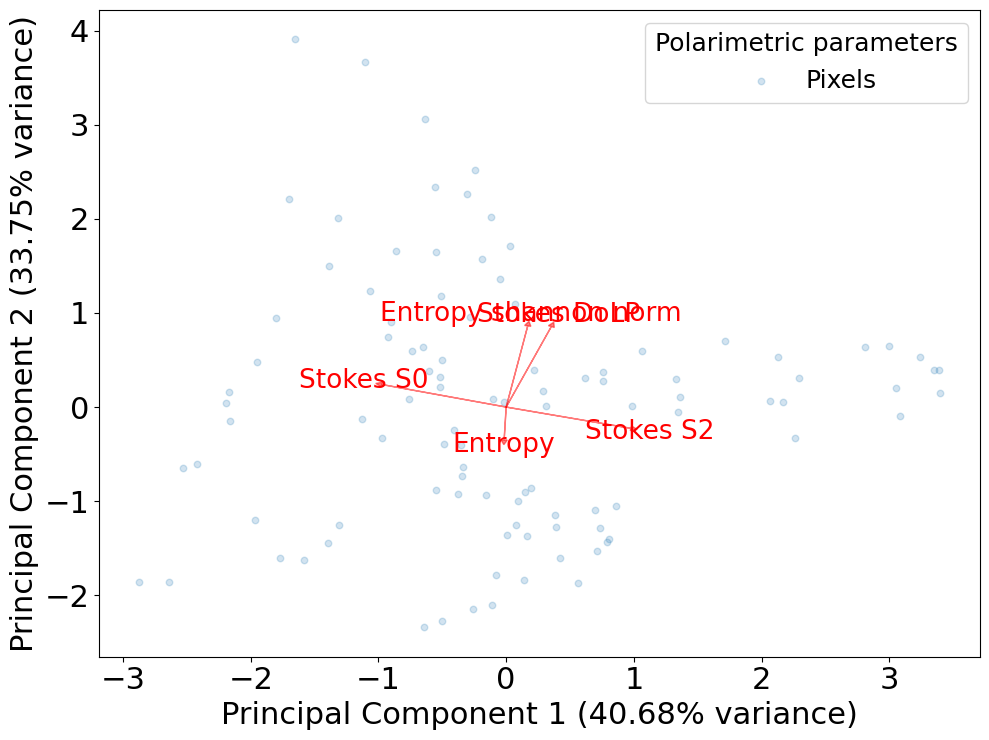

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes las siguientes variables definidas:
# - X_flat_valid: datos de entrada correspondientes a los píxeles válidos, de forma (n_valid_pixels, n_bandas, n_imágenes)
# - y_flat_valid: etiquetas correspondientes a los píxeles válidos, de forma (n_valid_pixels,)


band_labels = ['Stokes S2', 'Stokes S0', 'Entropy', 'Entropy shannon norm', 'Stokes DoLP']

# Paso 1: Promediar las bandas a través del tiempo para reducir la dimensionalidad
# Esto nos dará una matriz de forma (n_valid_pixels, n_bandas)
X_mean_time = np.mean(X_flat_valid, axis=2)  # Promedia a lo largo de la dimensión del tiempo

# Asegúrate de que X_mean_time tenga el mismo número de columnas que el tamaño de band_labels
X_mean_time = X_mean_time[:, 1:]  # Eliminar la primera columna correspondiente a 'Julian Days'

# Paso 2: Eliminar muestras con valores faltantes o inválidos
valid_mask = ~np.isnan(X_mean_time).any(axis=1) & (X_mean_time != -9999).all(axis=1)
X_mean_time_valid = X_mean_time[valid_mask]

# Paso 3: Escalar los datos antes de PCA (media cero y varianza unitaria)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mean_time_valid)

# Paso 4: Realizar PCA
n_components = 2  # Para el biplot, necesitamos dos componentes principales
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Obtener el porcentaje de varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Convertir a porcentaje

# Paso 5: Obtener las cargas (loadings) de las variables originales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Paso 6: Crear el biplot con ajustes de tamaño
plt.figure(figsize=(10, 7.5))

# Plot de los scores (proyecciones de las muestras en los componentes principales)
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.2, s=22, label='Pixels')

# Añadir vectores de las variables originales (loadings)
for i, (loading_x, loading_y) in enumerate(loadings):
    plt.arrow(0, 0, loading_x, loading_y, color='red', alpha=0.5, head_width=0.05, head_length=0.05)
    plt.text(loading_x * 1.15, loading_y * 1.15, band_labels[i], color='red', ha='center', va='center', fontsize=19)

# Actualizar las etiquetas de los ejes para incluir el porcentaje de varianza explicada
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2f}% variance)', fontsize=22)
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2f}% variance)', fontsize=22)

# Ajustar el título, leyenda y otros elementos visuales
plt.title('', fontsize=16)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(title='Polarimetric parameters', fontsize=18, title_fontsize='18', loc='upper right')
plt.grid(False)
plt.tight_layout()

# Mostrar el gráfico
plt.show()




In [ ]:
# 1. Dataset

# Reemplaza estas variables con tus datos reales

# Definir el dataset personalizado
class PixelDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convertir a tensores y ajustar dimensiones para que sean compatibles con el modelo
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        X = X.unsqueeze(-1).unsqueeze(-1)  # Agregar dimensiones espaciales ficticias (1x1)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return X, y

# Definir el Modelo CNN 3D Pixel a Pixel sin capas de normalización
class CNN3DModelPixelwise(nn.Module):
    def __init__(self, num_bands, num_images, dropout_rate=0.1):
        super(CNN3DModelPixelwise, self).__init__()

        # Capas convolucionales ajustadas para dimensiones espaciales de 1x1
        self.conv1 = nn.Conv3d(in_channels=num_bands, out_channels=32,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv1b = nn.Conv3d(in_channels=32, out_channels=32,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64,
                               kernel_size=(3, 1, 1), padding=(1, 0, 0))
        self.conv2b = nn.Conv3d(in_channels=64, out_channels=64,
                                kernel_size=(3, 1, 1), padding=(1, 0, 0))
        # Capa de convolución temporal para condensar la información temporal
        self.conv_temporal = nn.Conv3d(in_channels=64, out_channels=64,
                                       kernel_size=(num_images, 1, 1))
        # Capa final de convolución
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=1, kernel_size=1)

        # Dropout para la regularización
        self.dropout = nn.Dropout3d(p=dropout_rate)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout(x)

        x = torch.relu(self.conv1b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2(x))
        x = self.dropout(x)

        x = torch.relu(self.conv2b(x))
        x = self.dropout(x)

        x = torch.relu(self.conv_temporal(x))
        x = self.dropout(x)

        x = self.conv3(x)
        x = x.squeeze()
        return x

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Establecer semillas para reproducibilidad
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# 2. División en datos de entrenamiento y prueba, especificando el grupo a dejar fuera
X = X_flat_valid
y = y_flat_valid
groups = location_flat_valid.astype(int)

# Especificar el grupo que deseas dejar fuera como conjunto de prueba
test_group = 3  # Cambia este valor al grupo que quieras dejar fuera

# Crear máscaras para separar los datos
train_mask = groups != test_group
test_mask = groups == test_group

# Dividir los datos en entrenamiento y prueba según las máscaras
X_train = X[train_mask]
y_train = y[train_mask]
groups_train = groups[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
groups_test = groups[test_mask]

print(f"Número de muestras en entrenamiento: {len(X_train)}")
print(f"Número de muestras en prueba (grupo {test_group}): {len(X_test)}")
print(f"Grupos en entrenamiento: {np.unique(groups_train)}")
print(f"Grupos en prueba: {np.unique(groups_test)}")

Usando el dispositivo: cpu
Número de muestras en entrenamiento: 91
Número de muestras en prueba (grupo 3): 10
Grupos en entrenamiento: [1 2 4 5]
Grupos en prueba: [3]


In [ ]:
# 3. Parámetros
# Definir la rejilla de hiperparámetros para el ajuste
param_grid = {
    'learning_rate': [0.08,0.05, 0.1, 0.001],
    'dropout_rate': [0.01, 0.1],
    'optimizer': ['Adam', 'Adagrad']
}

grid = list(ParameterGrid(param_grid))

# Obtener los valores únicos de y_train y y_test
unique_y_train = np.unique(y_train)
unique_y_test = np.unique(y_test)

print("Valores únicos en y_train:", unique_y_train)
print("Valores únicos en y_test:", unique_y_test)

# 4. Validación cruzada k-fold en los datos de entrenamiento
unique_groups = np.unique(groups_train)
n_splits = min(4, len(unique_groups))
random_state = 42

from sklearn.model_selection import GroupKFold


Valores únicos en y_train: [55. 78. 84. 88.]
Valores únicos en y_test: [89.]


In [ ]:
gkf = GroupKFold(n_splits=n_splits)

# Variables para almacenar los mejores hiperparámetros y score
best_params = None
best_score = np.inf  # Porque queremos minimizar el RMSE

for params in grid:
    print(f"\nEvaluando hiperparámetros: {params}")
    fold_metrics = []

    # Configurar los hiperparámetros actuales
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    for fold, (train_idx_fold, val_idx_fold) in enumerate(gkf.split(X_train, y_train, groups=groups_train)):
        print(f"  Fold {fold + 1}/{n_splits}")
        print(f"    Número de muestras en entrenamiento: {len(train_idx_fold)}")
        print(f"    Número de muestras en validación: {len(val_idx_fold)}")

        # Verificar que el conjunto de validación no esté vacío
        if len(val_idx_fold) == 0:
            print(f"    Fold {fold + 1} omitido por falta de muestras en validación.")
            continue

        # Dividir los datos en entrenamiento y validación
        X_fold_train, X_fold_val = X_train[train_idx_fold], X_train[val_idx_fold]
        y_fold_train, y_fold_val = y_train[train_idx_fold], y_train[val_idx_fold]

        # Normalizar los datos basados en X_fold_train
        num_bands = X_fold_train.shape[1]
        num_images = X_fold_train.shape[2]

        means = np.mean(X_fold_train, axis=(0, 2))
        stds = np.std(X_fold_train, axis=(0, 2))
        stds[stds == 0] = 1  # Evitar divisiones por cero

        def normalize_data(X, means, stds):
            return (X - means[np.newaxis, :, np.newaxis]) / stds[np.newaxis, :, np.newaxis]

        X_fold_train_norm = normalize_data(X_fold_train, means, stds)
        X_fold_val_norm = normalize_data(X_fold_val, means, stds)

        # Crear datasets y dataloaders
        train_dataset = PixelDataset(X_fold_train_norm, y_fold_train)
        val_dataset = PixelDataset(X_fold_val_norm, y_fold_val)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Definir el modelo con los hiperparámetros actuales
        model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

        # Definir la función de pérdida y el optimizador
        criterion = nn.L1Loss()
        if optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

        # Entrenar el modelo en X_fold_train
        num_epochs = 30  # Ajusta según sea necesario
        for epoch in range(num_epochs):
            model.train()
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Evaluar el modelo en el conjunto de entrenamiento para calcular R²
        model.eval()
        all_train_preds = []
        all_train_trues = []
        with torch.no_grad():
            for inputs, targets in train_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_train_preds.extend(preds)
                all_train_trues.extend(trues)

        # Evaluar el modelo en el conjunto de validación
        all_val_preds = []
        all_val_trues = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)

                preds = outputs.cpu().numpy()
                trues = targets.cpu().numpy()

                all_val_preds.extend(preds)
                all_val_trues.extend(trues)

        # Calcular métricas para el conjunto de validación
        if len(all_val_trues) > 0:
            val_rmse = np.sqrt(mean_squared_error(all_val_trues, all_val_preds))
            val_mae = mean_absolute_error(all_val_trues, all_val_preds)
            val_bias = np.mean(np.array(all_val_preds) - np.array(all_val_trues))
            val_pbias = 100 * np.sum(np.array(all_val_preds) - np.array(all_val_trues)) / np.sum(np.array(all_val_trues))
        else:
            val_rmse = np.nan
            val_mae = np.nan
            val_bias = np.nan
            val_pbias = np.nan

        print(f"    RMSE en validación: {val_rmse:.4f}")
        print(f"    MAE en validación: {val_mae:.4f}")
        print(f"    Bias en validación: {val_bias:.4f}")
        print(f"    PBIAS en validación: {val_pbias:.4f}%")

        # Guardar las métricas de este fold
        fold_metric = {
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_bias': val_bias,
            'val_pbias': val_pbias
        }
        fold_metrics.append(fold_metric)

    # Calcular las métricas promedio de todos los folds
    mean_metrics = {
        'mean_val_rmse': np.nanmean([m['val_rmse'] for m in fold_metrics]),
        'mean_val_mae': np.nanmean([m['val_mae'] for m in fold_metrics]),
        'mean_val_bias': np.nanmean([m['val_bias'] for m in fold_metrics]),
        'mean_val_pbias': np.nanmean([m['val_pbias'] for m in fold_metrics]),
    }

    # Imprimir las métricas promedio
    print(f"Resultados promedio para los hiperparámetros {params}:")
    print(f"  RMSE promedio en validación: {mean_metrics['mean_val_rmse']:.4f}")
    print(f"  MAE promedio en validación: {mean_metrics['mean_val_mae']:.4f}")
    print(f"  Bias promedio en validación: {mean_metrics['mean_val_bias']:.4f}")
    print(f"  PBIAS promedio en validación: {mean_metrics['mean_val_pbias']:.4f}%")


    # Actualizar los mejores hiperparámetros si es necesario
    if mean_metrics['mean_val_rmse'] < best_score:
        best_score = mean_metrics['mean_val_rmse']
        best_params = params

print(f"\nMejores hiperparámetros encontrados: {best_params} con RMSE promedio en validación de {best_score:.4f}")


Evaluando hiperparámetros: {'dropout_rate': 0.01, 'learning_rate': 0.08, 'optimizer': 'Adam'}
  Fold 1/4
    Número de muestras en entrenamiento: 63
    Número de muestras en validación: 28
    RMSE en validación: 17.4016
    MAE en validación: 16.7703
    Bias en validación: -16.7703
    PBIAS en validación: -19.9647%
  Fold 2/4
    Número de muestras en entrenamiento: 64
    Número de muestras en validación: 27
    RMSE en validación: 73.5496
    MAE en validación: 73.5496
    Bias en validación: -73.5496
    PBIAS en validación: -94.2944%
  Fold 3/4
    Número de muestras en entrenamiento: 72
    Número de muestras en validación: 19
    RMSE en validación: 50.6482
    MAE en validación: 50.6482
    Bias en validación: -50.6482
    PBIAS en validación: -92.0877%
  Fold 4/4
    Número de muestras en entrenamiento: 74
    Número de muestras en validación: 17
    RMSE en validación: 9.5947
    MAE en validación: 8.7842
    Bias en validación: -8.7842
    PBIAS en validación: -9.9820%
R

Epoch 1/30, Loss: 60.9814
Epoch 2/30, Loss: 54.0405
Epoch 3/30, Loss: 52.5356
Epoch 4/30, Loss: 48.9109
Epoch 5/30, Loss: 36.4186
Epoch 6/30, Loss: 17.0147
Epoch 7/30, Loss: 12.6166
Epoch 8/30, Loss: 12.8841
Epoch 9/30, Loss: 10.1801
Epoch 10/30, Loss: 10.1258
Epoch 11/30, Loss: 10.2137
Epoch 12/30, Loss: 9.2559
Epoch 13/30, Loss: 9.8572
Epoch 14/30, Loss: 10.6499
Epoch 15/30, Loss: 9.2815
Epoch 16/30, Loss: 8.0556
Epoch 17/30, Loss: 7.8090
Epoch 18/30, Loss: 7.7201
Epoch 19/30, Loss: 7.9354
Epoch 20/30, Loss: 6.9960
Epoch 21/30, Loss: 9.2542
Epoch 22/30, Loss: 4.7140
Epoch 23/30, Loss: 11.5146
Epoch 24/30, Loss: 6.9854
Epoch 25/30, Loss: 5.9719
Epoch 26/30, Loss: 4.2715
Epoch 27/30, Loss: 3.2232
Epoch 28/30, Loss: 8.9643
Epoch 29/30, Loss: 7.0646
Epoch 30/30, Loss: 3.5809

Métricas en el Conjunto de Entrenamiento:
RMSE: 5.0755
MAE: 3.8299
R²: 0.8083
Bias: 3.1121
PBIAS: 4.0442%


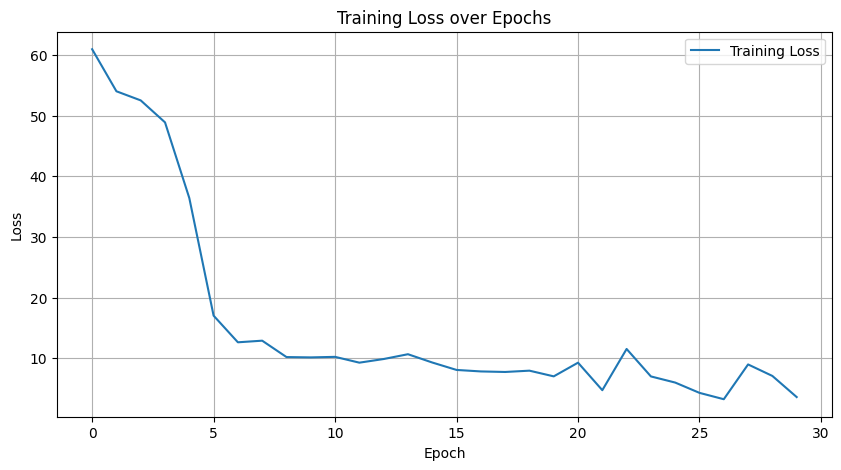

In [ ]:
# 5. Reentrenamiento con los mejores parámetros
# Normalizar los datos de entrenamiento completos
num_bands = X_train.shape[1]
num_images = X_train.shape[2]

means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)
stds[stds == 0] = 1

def normalize_data(X, means, stds):
    return (X - means[np.newaxis, :, :]) / stds[np.newaxis, :, :]

X_train_norm = normalize_data(X_train, means, stds)

# Crear el dataset y dataloader para los datos de entrenamiento completos
train_dataset = PixelDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

# Crear el modelo con los mejores hiperparámetros
dropout_rate = 0.01
learning_rate = 0.1
optimizer_name = best_params['optimizer']

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images, dropout_rate=dropout_rate).to(device)

# Definir la función de pérdida y el optimizador con los mejores hiperparámetros
criterion = nn.L1Loss()
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

# Entrenar el modelo
num_epochs = 30   # Ajusta según sea necesario
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Evaluar el modelo en el conjunto de entrenamiento completo
model.eval()
all_train_preds = []
all_train_trues = []

with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        all_train_preds.extend(outputs.cpu().numpy())
        all_train_trues.extend(targets.cpu().numpy())

# Calcular métricas en el conjunto de entrenamiento completo
train_mse = mean_squared_error(all_train_trues, all_train_preds)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(all_train_trues, all_train_preds)
train_r2 = r2_score(all_train_trues, all_train_preds)
train_bias = np.mean(np.array(all_train_preds) - np.array(all_train_trues))
train_pbias = 100 * np.sum(np.array(all_train_preds) - np.array(all_train_trues)) / np.sum(np.array(all_train_trues))

print('\nMétricas en el Conjunto de Entrenamiento:')
print(f'RMSE: {train_rmse:.4f}')
print(f'MAE: {train_mae:.4f}')
print(f'R²: {train_r2:.4f}')
print(f'Bias: {train_bias:.4f}')
print(f'PBIAS: {train_pbias:.4f}%')

# Plot de la función de pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import pandas as pd


# Crear un DataFrame con los valores observados y predichos
df_results = pd.DataFrame({
    'Valores Observados': all_train_preds,
    'Valores Predichos':  all_train_trues
})

# Especificar la ruta y el nombre del archivo Excel
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx'

# Guardar el DataFrame en un archivo Excel
df_results.to_excel(excel_file_path, index=False)

print(f"Resultados exportados exitosamente a {excel_file_path}")

Resultados exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx


R²: 0.7775
RMSE: 5.0755
MAE: 3.8299
Bias: -3.1121
PBIAS: -3.8870%
Pearson Correlation: 0.9383


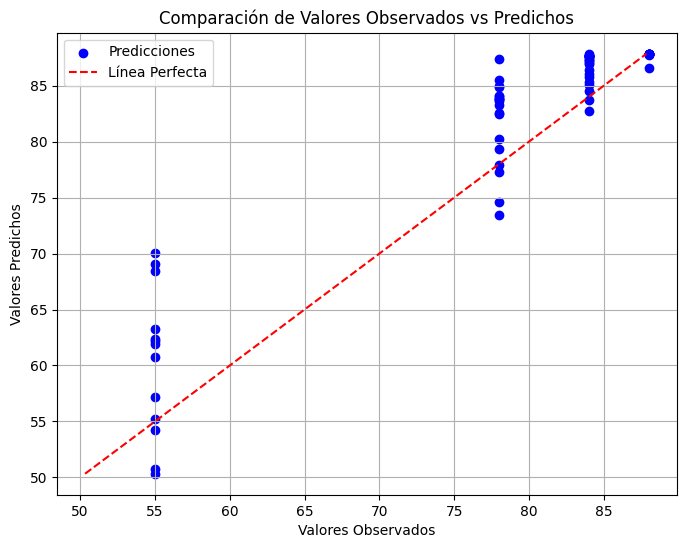

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr

# Especificar la ruta del archivo Excel
excel_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_SAR.xlsx'

# Leer el archivo Excel
df_results = pd.read_excel(excel_file_path)

# Extraer los valores observados y predichos
observed_values = df_results['Valores Observados']
predicted_values = df_results['Valores Predichos']

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(observed_values, predicted_values))

# Calcular MAE
mae = mean_absolute_error(observed_values, predicted_values)

# Calcular R²
r2 = r2_score(observed_values, predicted_values)

# Calcular Bias
bias = np.mean(predicted_values - observed_values)

# Calcular PBIAS
pbias = 100 * np.sum(predicted_values - observed_values) / np.sum(observed_values)

# Calcular Correlación de Pearson
pearson_corr, _ = pearsonr(observed_values, predicted_values)

# Mostrar los resultados
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Bias: {bias:.4f}")
print(f"PBIAS: {pbias:.4f}%")
print(f"Pearson Correlation: {pearson_corr:.4f}")

# Generar el gráfico de valores observados vs predichos
plt.figure(figsize=(8, 6))
plt.scatter(predicted_values, observed_values, label='Predicciones', color='blue')
plt.plot([observed_values.min(), observed_values.max()],
         [observed_values.min(), observed_values.max()],
         color='red', label='Línea Perfecta', linestyle='--')

plt.title('Comparación de Valores Observados vs Predichos')
plt.xlabel('Valores Observados')
plt.ylabel('Valores Predichos')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 6. Evaluación final en el conjunto de prueba
# Normalizar los datos de prueba usando las estadísticas de los datos de entrenamiento
X_test_norm = normalize_data(X_test, means, stds)

# Crear el dataset y dataloader para los datos de prueba
test_dataset = PixelDataset(X_test_norm, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluar el modelo en los datos de prueba
model.eval()

all_test_predictions = []
all_test_true_values = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        preds = outputs.cpu().numpy()
        trues = targets.cpu().numpy()

        all_test_predictions.extend(preds)
        all_test_true_values.extend(trues)

# Calcular métricas en los datos de prueba
mse = mean_squared_error(all_test_true_values, all_test_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_test_true_values, all_test_predictions)
r2 = r2_score(all_test_true_values, all_test_predictions)
bias = np.mean(np.array(all_test_predictions) - np.array(all_test_true_values))
pbias = 100 * np.sum(np.array(all_test_predictions) - np.array(all_test_true_values)) / np.sum(np.array(all_test_true_values))


print('\nMétricas en el Conjunto de Prueba:')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')
print(f'Bias: {bias:.4f}')
print(f'PBIAS: {pbias:.4f}%')


Métricas en el Conjunto de Prueba:
RMSE: 2.3387
MAE: 1.8109
R²: 0.0000
Bias: -1.8109
PBIAS: -2.0347%


In [ ]:
import pandas as pd

# Crear un DataFrame con los valores observados y predichos del conjunto de prueba
df_test_results = pd.DataFrame({
    'Valores Observados': np.array(all_test_predictions).reshape(-1),
    'Valores Predichos': np.array(all_test_true_values).reshape(-1)
})

# Especificar la ruta y el nombre del archivo Excel para el conjunto de prueba
excel_test_file_path = '/content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_SAR.xlsx'

# Guardar el DataFrame en un archivo Excel
df_test_results.to_excel(excel_test_file_path, index=False)

print(f"Resultados del conjunto de prueba exportados exitosamente a {excel_test_file_path}")

Resultados del conjunto de prueba exportados exitosamente a /content/drive/MyDrive/TF_data/Observed_vs_predicted/Observed_vs_predicted_siembra_2022_testing_SAR.xlsx


In [ ]:
print(all_test_predictions)

[82.82445, 87.7689, 87.61744, 86.890236, 87.819336, 87.81331, 87.714355, 87.85472, 87.846954, 87.74112]


In [ ]:
# Guardado del modelo final
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'means': means,
    'stds': stds,
    'num_bands': num_bands,
    'num_images': num_images,
    'best_params': best_params
}, model_path)

print(f"\nModelo final guardado en {model_path}")


Modelo final guardado en /content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth


In [ ]:
# Paso 1: Cargar el modelo guardado y sus parámetros
device = 'cpu'
# Guardado del modelo final
model_path = "/content/drive/MyDrive/TF_data/Predictions/modelo_siembra_2022_SAR.pth"

model = CNN3DModelPixelwise(num_bands=num_bands, num_images=num_images).to(device)

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
means = checkpoint['means']
stds = checkpoint['stds']
num_bands = checkpoint['num_bands']
num_images = checkpoint['num_images']
model.eval()  # Cambiar a modo de evaluación

<ipython-input-86-82530bbaf700>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


CNN3DModelPixelwise(
  (conv1): Conv3d(6, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv1b): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv2b): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0))
  (conv_temporal): Conv3d(64, 64, kernel_size=(18, 1, 1), stride=(1, 1, 1))
  (conv3): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (dropout): Dropout3d(p=0.1, inplace=False)
)

Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif
Días julianos calculados: 3 para la imagen 1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif
Las bandas del archivo 1_Subset_S1A_IW_SLC_1SDV_20220704T191748_20220704T191815_043955_053F39_0238_Orb_Cal_Deb_Spk_TC.tif no tienen nombres. Asignando nombres predefinidos.
Cargando y enmascarando imagen: /content/drive/MyDrive/TF_data/SAR_images/1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif
Días julianos calculados: 15 para la imagen 1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif
Las bandas del archivo 1_Subset_S1A_IW_SLC_1SDV_20220716T191749_20220716T191816_044130_054475_E70F_Orb_Cal_Deb_Spk_TC.tif no tienen nombres. Asignando nombres predefinidos.
Cargando y enmascarando

<ipython-input-87-9da6e79c1e3b>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Imagen predicha guardada en /content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_SAR.tif


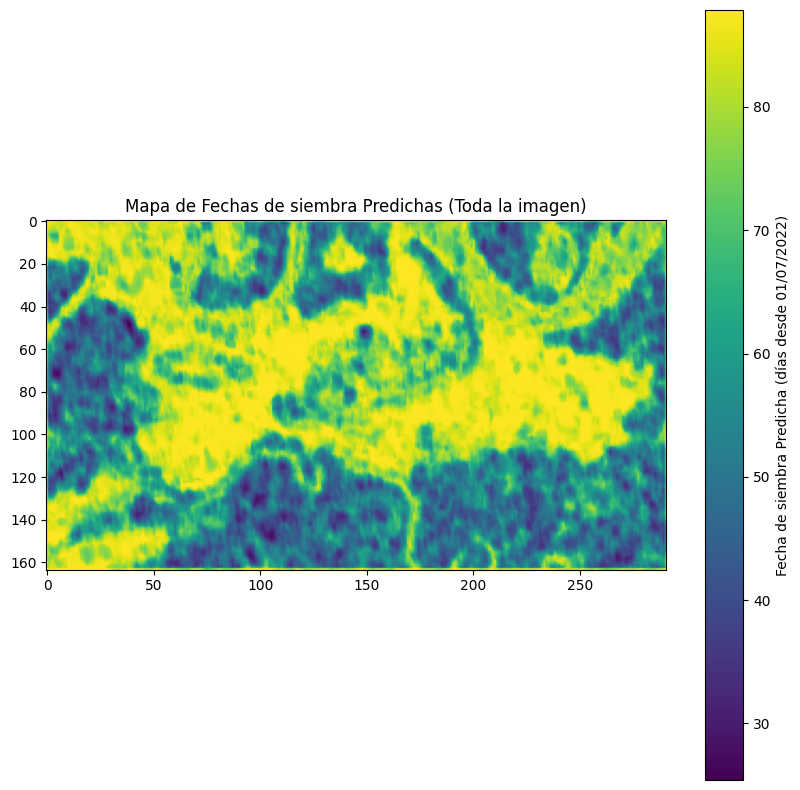

In [ ]:
# Cargar la imagen completa para predicción
def load_full_sequence_images(image_paths, target_band_names=['dias_julianos',  'Stokes2_g2', 'Stokes2_g0', 'entropy', 'entropy_shannon_norm', 'Stokes2_DoLP']):
    sequence = []
    pixel_counts = []
    labels = []  # Aquí almacenamos las etiquetas asociadas a cada polígono
    all_geometries = gdf['geometry']
    if len(image_paths) == 0:
        print("No se encontraron imágenes para el rango de fechas especificado.")
        return None

    for image_path in image_paths:
        print(f"Cargando y enmascarando imagen: {image_path}")

        # Extraer la fecha de la imagen del nombre (sin la extensión .tif)
        filename = os.path.basename(image_path)
        filename_no_ext, _ = os.path.splitext(filename)
        parts = filename_no_ext.split('_')

        if len(parts) < 7 :
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        part5 = parts[6]
        file_date_str = part5[:8]
        try:
            file_date_str_formatted = f"{file_date_str[:4]}-{file_date_str[4:6]}-{file_date_str[6:]}"
            image_date = datetime.strptime(file_date_str_formatted, '%Y-%m-%d')
            julian_days = (image_date - base_date).days
            print(f"Días julianos calculados: {julian_days} para la imagen {filename}")
        except ValueError:
            print(f"Error al extraer la fecha del archivo {filename}")
            continue

        # Abrir la imagen con rasterio y manejar las bandas
        with rasterio.open(image_path) as src:
            band_names = list(src.descriptions)
            if all(band_name is None for band_name in band_names):
                print(f"Las bandas del archivo {filename} no tienen nombres. Asignando nombres predefinidos.")
                band_names = target_band_names[1:]

            selected_bands = select_band_by_name(src, band_names, target_band_names[1:])

            if selected_bands is not None:
                selected_bands = selected_bands.astype(np.float32)
                selected_bands[np.isnan(selected_bands)] = -1

                # Crear una banda para los días julianos con el mismo tamaño espacial que las imágenes
                julian_band = np.full((1, selected_bands.shape[1], selected_bands.shape[2]), julian_days, dtype=np.float32)

                # Concatenar la banda de días julianos con las bandas seleccionadas
                stacked_bands = np.vstack((julian_band, selected_bands))

                sequence.append(stacked_bands)

            else:
                print(f"No se seleccionaron bandas para la imagen {image_path}.")

    if len(sequence) > 0:

        return np.stack(sequence, axis=0)
    else:
        print("No se pudo cargar ninguna imagen.")
        return None, None, None


# Predicción sobre toda la imagen (usando el modelo entrenado)
# Cargar la imagen completa para predicción
X_full_sequences = load_full_sequence_images(image_paths_in_range)

# Verificar que se cargaron las secuencias
if X_full_sequences is not None:
    print(f"Shape de X_full_sequences: {X_full_sequences.shape}")  # (n_imágenes, n_bandas, alto, ancho)
else:
    raise ValueError("No se pudieron cargar las secuencias de imágenes completas.")

# Reorganizar los datos para que coincidan con el formato del modelo
# Transponer a (n_bandas, n_imágenes, alto, ancho)
X_full = X_full_sequences.transpose(1, 0, 2, 3)
X_full = X_full.astype(np.float32)

# Normalizar la imagen completa usando las medias y desviaciones del modelo entrenado
def normalize_dataset(X_data, means, stds):
    return (X_data - means[:, :, np.newaxis, np.newaxis]) / stds[:, :, np.newaxis, np.newaxis]

X_full_norm = normalize_dataset(X_full, means, stds)

# Aplanar las dimensiones espaciales para obtener una lista de píxeles
X_full_flat = X_full_norm.reshape(num_bands, num_images, -1).transpose(2, 0, 1)  # (n_pixels, num_bands, num_imágenes)

print(f"Shape de X_full_flat: {X_full_flat.shape}")  # (n_pixels, num_bands, num_imágenes)

# Crear un Dataset y DataLoader para la predicción completa
full_dataset = PixelDataset(X_full_flat, np.zeros(X_full_flat.shape[0]))  # Las etiquetas son irrelevantes aquí
full_loader = DataLoader(full_dataset, batch_size=24, shuffle=False)

# Cargar el modelo entrenado
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Aplicar el modelo entrenado sobre toda la imagen
all_predictions = []

with torch.no_grad():
    for inputs, _ in full_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.cpu().numpy()
        all_predictions.extend(preds)

# Reconstruir la imagen de predicciones
predictions_array = np.array(all_predictions)
height, width = X_full_sequences.shape[2], X_full_sequences.shape[3]
predictions_image = predictions_array.reshape(height, width)

# Guardar la imagen predicha
with rasterio.open(image_paths_in_range[0]) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1)

output_path = '/content/drive/MyDrive/TF_data/Fechas de siembra predichas/predicciones_fecha_siembra_2022_validacion_cruzada_SAR.tif'
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(predictions_image, 1)

print(f"Imagen predicha guardada en {output_path}")

# Visualizar la imagen predicha
plt.figure(figsize=(10, 10))
plt.imshow(predictions_image, cmap='viridis')
plt.colorbar(label='Fecha de siembra Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de siembra Predichas (Toda la imagen)')
plt.show()


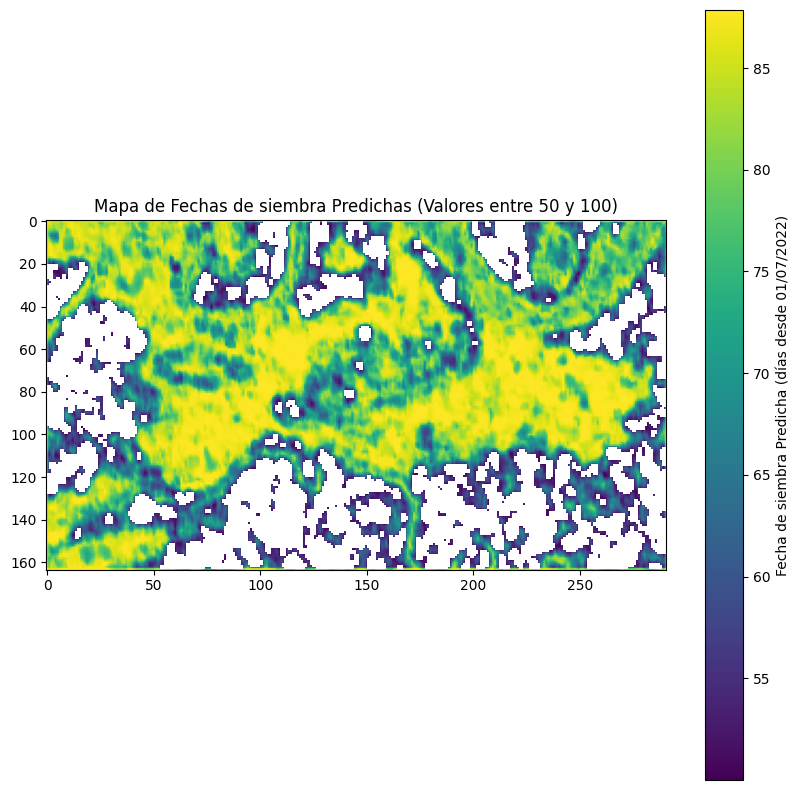

In [ ]:
import numpy as np

# Crear una máscara para valores fuera del rango 50-100
masked_predictions = np.ma.masked_outside(predictions_image, 50, 90)

# Visualizar la imagen predicha con la máscara
plt.figure(figsize=(10, 10))
plt.imshow(masked_predictions, cmap='viridis')
plt.colorbar(label='Fecha de siembra Predicha (días desde 01/07/2022)')
plt.title('Mapa de Fechas de siembra Predichas (Valores entre 50 y 100)')
plt.show()


In [ ]:
# Verificar las dimensiones de las matrices
print("Shape de X_full_sequences:", X_full_sequences.shape)  # (num_times,num_bands height, width)
print("Shape de means:", means.shape)  # (num_bands, num_times)
print("Shape de stds:", stds.shape)    # (num_bands, num_times)


Shape de X_full_sequences: (16, 8, 164, 291)
Shape de means: (8, 16)
Shape de stds: (8, 16)
